In [ ]:
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
import cv2
import numpy as np
import math
import torchvision.transforms.functional as functional
import matplotlib.pyplot as plt
from PIL import Image

# Forward (noising) process

A diffusion model gradually corrupts an image over T timesteps by adding a small amount of Gaussian noise at each step. As the noise accumulates, the signal-to-noise ratio decreases, and by the final step the image is essentially pure noise—indistinguishable from a sample of a standard Gaussian.

![noise](https://sushant-kumar.com/blog/ddpm-diffusion-process.png)

Math:

Choose a noise schedule
${β_t}$ with $0 < β_t < 1$
$$q(x_t | x_{t-1}) = Normal(x_t; mean = \sqrt{1 − β_t} · x_{t-1}, cov = β_t · I)$$

Equivalently,
$$x_t = \sqrt{ᾱ_t} · x_0 + \sqrt{1 − ᾱ_t} · ε$$
where $ᾱ_t = ∏_{s=1}^t (1 − β_s)$ and $ε$ ~ $Normal(0, I)$.
As t grows, $ᾱ_t → 0$, so $x_T ≈ ε$ (pure Gaussian noise).

![](https://raw.githubusercontent.com/Xrenya/intro_diffusion/refs/heads/main/assets/forward_diffusion_process.png)

In [ ]:
#@title Download image
!wget -q https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png

### The noise process with fixed $\beta$

There are several reason to use schedule $\beta$ instead of fixed:

1. With fixed β, the signal-to-noise ratio (SNR) drops very unevenly—huge changes early, tiny changes later. A schedule (e.g., cosine) spaces steps more evenly in log-SNR, so each step learns a similarly hard denoising task.
2. Better sample quality for the same number of steps: Scheduled β allocates small noise early (preserve structure) and larger noise late (finish mixing to pure noise), which improves fidelity and diversity at a fixed T.
3. Stable reverse dynamics: The stochasticity you inject when sampling, $σ_t^2 = \beta_t$, depends on $\beta$ and $ᾱ_t$. Poorly chosen constant $\beta$ makes some steps nearly deterministic and others overly noisy, which harms synthesis. Schedules keep $σ_t$ well-behaved.

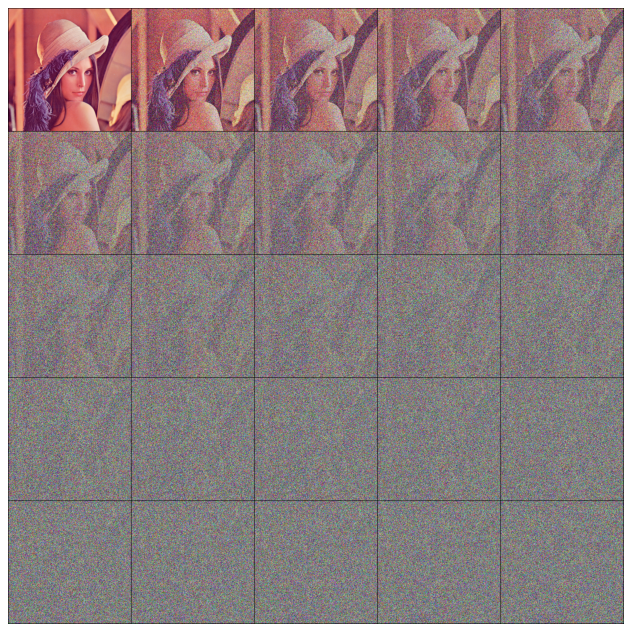

In [ ]:
# Define parameters
timesteps: int = 24
beta: float = 0.3

# Define functions
def add_noise(x, beta):
    noise = torch.randn_like(x)
    return math.sqrt(1 - beta) * x + math.sqrt(beta) * noise

def normalize(image: torch.Tensor) -> torch.Tensor:
    image -= 0.5
    image /= 0.5
    return image

def denormalize(image: torch.Tensor) -> torch.Tensor:
    image *= 0.5
    image += 0.5
    return image

# Apply noise with fixed beta
image = cv2.imread("Lenna_(test_image).png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

x = torch.tensor(image).permute(2, 0, 1)
x = x.to(torch.float32) / 255.
x = normalize(x)

output = []
output.append(x.clone())

for i in range(timesteps):
    x = add_noise(x, beta)
    output.append(x.clone())
output = torch.stack(output, dim=0)
output = denormalize(output).clamp(0, 1)
grid = make_grid(output, nrow=5)
grid = functional.to_pil_image(grid)


plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(np.array(grid))
plt.axis("off")
plt.show()

### Using a schedule for $\beta$

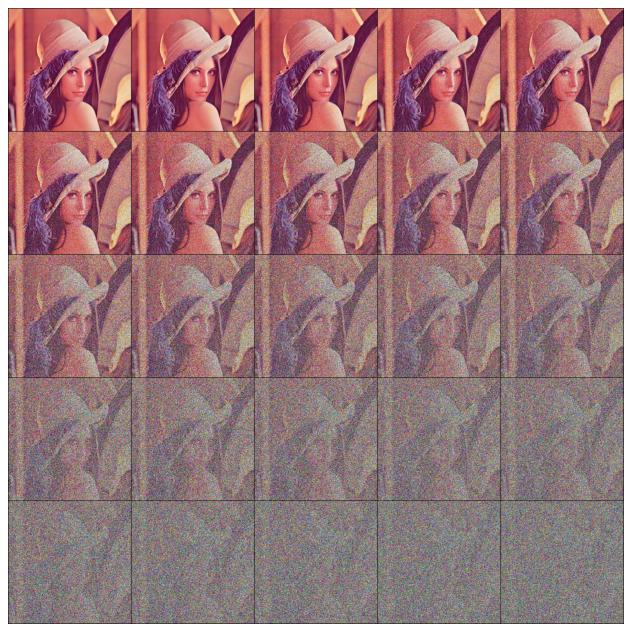

In [ ]:
def get_beta_schedule(
    timestemps: int,
    beta_start: float = 1e-4,
    beta_end: float = 0.6
):
    return torch.linspace(beta_start, beta_end, timestemps)

class NoiseScheduler:
    def __init__(
        self,
        timestemps: int = 24,
        beta_start: float = 1e-4,
        beta_end: float = 0.6
    ):
        super().__init__()
        self.timestemps = timestemps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.beta = get_beta_schedule(timestemps, beta_start, beta_end)

    def add_noise(self, x: torch.Tensor, t: int):
        """
        Adds a single step of noise
        :param x: image we are adding noise to
        :param t: step number, 0 indexed (0 <= t < steps)
        :return: image with noise added
        """
        beta = self.beta[t]
        noise = torch.randn_like(x)
        return math.sqrt(1 - beta)**0.5 * x + math.sqrt(beta) * noise


# Apply noise with fixed beta
image = cv2.imread("Lenna_(test_image).png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

x = torch.tensor(image).permute(2, 0, 1)
x = x.to(torch.float32) / 255.
x = normalize(x)

output = []
output.append(x.clone())

noise = NoiseScheduler()
for t in range(timesteps):
    x = noise.add_noise(x, t)
    output.append(x.clone())

output = torch.stack(output, dim=0)
output = denormalize(output).clamp(0, 1)
grid = make_grid(output, nrow=5)
grid = functional.to_pil_image(grid)


plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(np.array(grid))
plt.axis("off")
plt.show()

The transition is smoother compared to the fixed $\beta$ even with the same number of steps.

#### Comparision of fixed $\beta$ vs $cosine$ function
Early steps cause a big SNR drop; late steps barely move the SNR. Cosine schedules are designed so log SNR changes more evenly across $t$. That why it is important to have a scheduled $\beta$ which allows to have a more stable and predictable training.

In [ ]:
def linear_beta_schedule(T, beta_start=1e-4, beta_end=2e-2):
    return torch.linspace(beta_start, beta_end, T)

def cosine_beta_schedule(T, s=0.008, max_beta=0.999):
    steps = T + 1
    t = torch.linspace(0, T, steps, dtype=torch.float64) / T
    f = torch.cos(((t + s) / (1 + s)) * math.pi / 2) ** 2
    f = f / f[0]
    betas = torch.minimum(
        1 - f[1:] / f[:-1],
        torch.tensor(max_beta, dtype=torch.float64)
    )
    return betas.float().clamp(1e-8, 0.999)

def log_snr(alpha_bars):
    ab = alpha_bars.clamp(1e-12, 1-1e-12)
    return torch.log(ab) - torch.log1p(-ab)

T = 1000
beta_const = torch.full((T,), 0.01)
beta_cos = cosine_beta_schedule(T)

def abars(b):
    return torch.cumprod(1 - b, dim=0)

d_const = torch.diff(log_snr(abars(beta_const)))
d_cos   = torch.diff(log_snr(abars(beta_cos)))

print("Const β | ΔlogSNR range:", float(d_const.min()), "to", float(d_const.max()))
print("Cosine  | ΔlogSNR range:", float(d_cos.min()), "to",   float(d_cos.max()))

Const β | ΔlogSNR range: -0.6981842517852783 to -0.010049819946289062
Cosine  | ΔlogSNR range: -6.907771110534668 to -0.006234169006347656


## Reverse (denoising) process

In the reverse, we would like to denoise an image, starting with pure Gaussian nose and removing some noise each timestep until we reach the final generated image. Of course, because the noise added at step is random, there is no way to deterministically recover the actual image. Instead, we'll train a model to approximate the noise at timestep $t$, given image $x_t$.

Assuming we have some model that can predict this, our training objective now becomings minimizing the *Kullback–Leibler divergence* between our predictions and the ground truth. Or in simpler terms, we want to minimize the surprise from predictions from our model, compared to the actual distribution:

$$
D_{KL}( q(x_{t−1} | x_t, x_0) || p_θ(x_{t−1} | x_t) )
$$

If our model is a good predictor of the noise, then when we step backwards, our final generated image won't be the actual image, but it should be contained in a similar distribution to our training data.

The simplified loss function becomes the mean squared error between the actual noise and the predicted noise.

$$
\left\| \epsilon - \epsilon_{\theta} \right\|^2
$$

Snippet that shows how the KL reduces to a (weighted) MSE on the noise:

$$
\begin{aligned}
&\text{Let } \beta_t \in (0,1),\quad \alpha_t := 1 - \beta_t,\quad
\bar{\alpha}_t := \prod_{s=1}^t \alpha_s. \\
&x_t \;=\; \sqrt{\bar{\alpha}_t}\, x_0 \;+\; \sqrt{1-\bar{\alpha}_t}\, \varepsilon,
\quad \varepsilon \sim \mathcal{N}(0, I). \\
&q(x_{t-1} \mid x_t, x_0) \;=\; \mathcal{N}\big(\mu_q,\, \tilde{\beta}_t I\big),
\quad \tilde{\beta}_t \;=\; \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t}\,\beta_t, \\
&\mu_q \;=\; \frac{1}{\sqrt{\alpha_t}}
\left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}}\, \varepsilon \right), \\
&p_\theta(x_{t-1} \mid x_t) \;=\; \mathcal{N}\big(\mu_\theta,\, \sigma_t^2 I\big), \quad
\mu_\theta \;=\; \frac{1}{\sqrt{\alpha_t}}
\left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}}\, \varepsilon_\theta(x_t,t) \right).
\end{aligned}
$$


$$
D_{\mathrm{KL}}\!\Big(q(x_{t-1}\!\mid x_t,x_0)\,\big\|\, p_\theta(x_{t-1}\!\mid x_t)\Big)
\;=\; \text{const}
\;+\; \frac{\beta_t^{2}}{2\,\sigma_t^{2}\,\alpha_t\,(1-\bar{\alpha}_t)}
\,\big\lVert \varepsilon - \varepsilon_\theta(x_t,t) \big\rVert_2^{2}.
$$


Aggregated training objective (sampling $t \sim \mathrm{Uniform}\{1,\dots,T\}$):
$$
\mathcal{L}(\theta)
= \mathbb{E}_{t,\,x_0,\,\varepsilon}\!
\left[
w_t \,\big\lVert \varepsilon - \varepsilon_\theta(x_t,t) \big\rVert_2^{2}
\right],
\quad
w_t = \frac{\beta_t^{2}}{2\,\sigma_t^{2}\,\alpha_t\,(1-\bar{\alpha}_t)}.
$$

In practice, the “simple loss” sets $w_t = 1$ (and fixes $\sigma_t^2$, e.g., to $\beta_t$ or $\tilde{\beta}_t$):
$$
\mathcal{L}_{\text{simple}}(\theta)
= \mathbb{E}_{t,\,x_0,\,\varepsilon}
\left[ \big\lVert \varepsilon - \varepsilon_\theta(x_t,t) \big\rVert_2^{2} \right].
$$

### Training loop

1. Sample image $x_0$ from our dataset
2. Sample timetep $t$ from Uniform$(1, \cdots, T)$
3. Sample Gaussian noise $\epsilon$ from $\mathcal{N}(0, 1)$
4. Compute our noised image $x_t$ using $x_0$, $t$, $\epsilon$
5. Predict noise $\epsilon_{\theta}$ from our model, given $(x_t, t)$
6. Calculate loss using the mean squared error, $\left\| \epsilon - \epsilon_{\theta} \right\|^2$

The simple model:
```python
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 3, 3, padding=1)
        self.linear = nn.Linear(1, 16)

    def forward(self, x, t):
        x = self.conv1(x)
        x = F.relu(x)
        t = t.to(torch.float)
        t = self.linear(t)
        x = x + t.view(-1, 16, 1, 1)
        x = self.conv2(x)
        return x
```

Training: sample a random timestep t, add noise to x0 to get x_t, and train the model to predict the noise ε at that noise level. Doing this for many t teaches the model to denoise from any level.

Inference: start from pure Gaussian noise $x_T$ and iterate $t = T,…,1$. At each step, predict $\epsilon_θ(x_t, t)$, use it to compute x_{t−1}, and repeat until $t = 0$.

```python
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model().to(device)
optim = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

loss_history = []
iterations = 1000

for epoch in range(epochs):
    for image in dataloader:
        optim.zero_grad()
        noise = torch.randn_like(image, device=device)
        t = torch.randint(0, noise_scheduler.steps, (1, 1), device=device)
        x_t = noise_scheduler.add_noise(image, t)
        pred_noise = model(x_t, t)
        loss = criterion(pref_noise, noise)
        loss_history.append(loss.item())
        loss.backward()
        optim.step()

```



# Sampling / Inference

#### Sampling:

1. Sample $x_T$ from the normal distribution $\mathcal{N}(0, 1)$
2. For $t = T, \cdots, 1$:
   1. Sample $z$ from the normal distribution $\mathcal{N}(0, 1)$ if $t > 1$, else $z = 0$
   2. Compute the mean $\mu_t$ and variance $\sigma^2_t$, using $x_t$ and our schedule vars ($\bar{\alpha}_t$, $\beta_t$, etc.)
   3. Compute the previous step $x_{t-1} = \mu_t + \sigma_t * z$
4. Return $x_0$

#### The formulas for $\mu_t$ and $\sigma^2_t$ are:

$$
\mu_{\theta}(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_{\theta}(x_t, t) \right)
$$

$$
\sigma^2_{\theta}(x_t, t) = \frac{1 - \bar{\alpha}_t}{\sqrt{1 - \bar{\alpha}_t}} \beta_t
$$


![](https://raw.githubusercontent.com/Xrenya/intro_diffusion/refs/heads/main/assets/reverse_diffusion_process.png)

In [ ]:
class NoiseScheduler(nn.Module):
    def __init__(
        self,
        timesteps: int = 24,
        beta_start: float = 1e-4,
        beta_end: float = 0.6
    ):
        super().__init__()
        self.timesteps = timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        beta = torch.linspace(beta_start, beta_end, timesteps)
        alpha = 1. - beta
        alpha_bar = torch.cumprod(alpha, 0)

        self.register_buffer('beta', beta)
        self.register_buffer('alpha', alpha)
        self.register_buffer('alpha_bar', alpha_bar)

    def add_noise(self, x: torch.Tensor, t: torch.Tensor, noise: torch.Tensor):
        """
        Adds a single step of noise
        :param x: image we are adding noise to
        :param t: step number, 0 indexed (0 <= t < steps)
        :return: image with noise added
        """
        alpha_bar = self.alpha_bar[t].view(-1, 1, 1, 1)
        return torch.sqrt(alpha_bar) * x + torch.sqrt(1 - alpha_bar) * noise

    def sample_prev_step(self, xt, t, pred_noise):
        z = torch.randn_like(xt)
        z[t.expand_as(z) == 0] = 0

        mean = (1 / torch.sqrt(self.alpha[t])) * (xt - (self.beta[t] / torch.sqrt(1 - self.alpha_bar[t])) * pred_noise)
        var = ((1 - self.alpha_bar[t - 1])  / (1 - self.alpha_bar[t])) * self.beta[t]
        sigma = torch.sqrt(var)

        x = mean + sigma * z
        return x


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 3, 3, padding=1)
        self.linear = nn.Linear(1, 16)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        x = self.conv1(x)
        x = self.relu(x)
        t = t.to(torch.float)
        t = self.linear(t)
        x = x + t.view(-1, 16, 1, 1)
        x = self.conv2(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model()
noise_scheduler = NoiseScheduler()
num_steps = 24
x = torch.randn(1, 3, 512, 512).to(device)
for step in range(num_steps - 1, -1, -1):
    t = torch.tensor(step, device=device).view(1,)
    pred_noise = model(x, t)
    x = noise_scheduler.sample_prev_step(x, t, pred_noise)

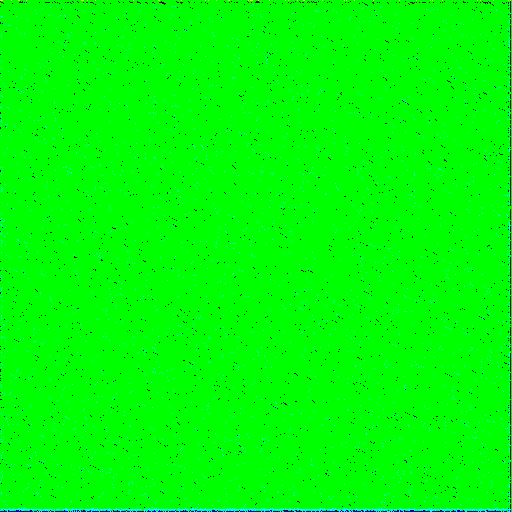

In [ ]:
x = denormalize(x).clamp(0, 1)
img = functional.to_pil_image(x[0])

img

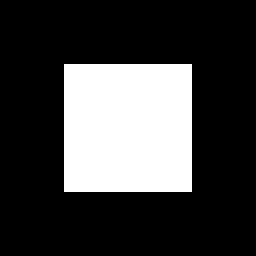

In [ ]:
x0 = torch.zeros(1, 3, 8, 8).to(device)
x0[:, :, 2:6, 2:6] = 1

img = functional.to_pil_image(x0[0])

img.resize((256, 256), Image.NEAREST)  # small image

In [ ]:
from PIL import Image

noise_scheduler = NoiseScheduler(
    timesteps=24,
    beta_start=1e-4,
    beta_end=0.6
).to(device)

model = Model().to(device)

x0 = torch.zeros(1, 3, 8, 8).to(device)
x0[:, :, 2:6, 2:6] = 1
x0 = normalize(x0)
img = functional.to_pil_image(denormalize(x0[0])).resize((256, 256), Image.NEAREST)
img.save("overfitting-target.png")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

iterations = 10000

for it in range(iterations):
    optimizer.zero_grad()
    noise = torch.randn_like(x0, device=device)
    t = torch.randint(0, noise_scheduler.timesteps, (1,), device=device)
    x_t = noise_scheduler.add_noise(x0, t, noise)
    pred_noise = model(x_t, t)
    loss = criterion(pred_noise, noise)
    if it % 100 == 0:
        print(f"Iteration {it}, Loss {loss.item()}")
    loss.backward()
    optimizer.step()

x = torch.randn(1, 3, 8, 8).to(device)
for step in range(num_steps-1, -1, -1):
    t = torch.tensor(step, device=device).view(1,)
    pred_noise = model(x, t)
    x = noise_scheduler.sample_prev_step(x, t, pred_noise)

x = denormalize(x).clamp(0, 1)
img = functional.to_pil_image(x[0]).resize((256, 256), Image.NEAREST)
img.save("overfitting-output.png")

Iteration 0, Loss 26.878381729125977
Iteration 100, Loss 0.9111168384552002
Iteration 200, Loss 0.5584754347801208
Iteration 300, Loss 0.9947980046272278
Iteration 400, Loss 0.307558536529541
Iteration 500, Loss 0.28169360756874084
Iteration 600, Loss 0.36171039938926697
Iteration 700, Loss 0.2968585789203644
Iteration 800, Loss 0.6312254071235657
Iteration 900, Loss 0.225516214966774
Iteration 1000, Loss 0.17502766847610474
Iteration 1100, Loss 0.6386702656745911
Iteration 1200, Loss 0.20325851440429688
Iteration 1300, Loss 0.2934021055698395
Iteration 1400, Loss 0.14900143444538116
Iteration 1500, Loss 0.22112064063549042
Iteration 1600, Loss 0.3391244113445282
Iteration 1700, Loss 0.26330384612083435
Iteration 1800, Loss 1.0091174840927124
Iteration 1900, Loss 0.6114591360092163
Iteration 2000, Loss 0.139426589012146
Iteration 2100, Loss 0.15171802043914795
Iteration 2200, Loss 1.2330471277236938
Iteration 2300, Loss 0.23100139200687408
Iteration 2400, Loss 1.2146919965744019
Iterat

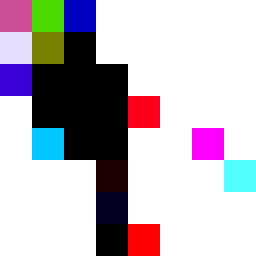

In [ ]:
img

### Model

```python
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim):
        super(ConvBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.proj = torch.nn.Linear(embed_dim, out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)

    def forward(self, x, embedding):
        x = self.conv1(x)
        emb_proj = self.proj(embedding).view(-1, x.size(1), 1, 1)
        x = torch.nn.functional.relu(x + emb_proj)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        return x


class Model(nn.Module):
    def __init__(self, num_steps=1000, embed_dim=16):
        super(Model, self).__init__()

        self.embed = torch.nn.Embedding(num_steps, embed_dim)

        self.enc1 = ConvBlock(1, 16, embed_dim)
        self.enc2 = ConvBlock(16, 32, embed_dim)
        self.bottleneck = ConvBlock(32, 64, embed_dim)
        self.upconv2 = torch.nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(64, 32, embed_dim)
        self.upconv1 = torch.nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(32, 16, embed_dim)
        self.final = torch.nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x, t):
        emb = self.embed(t)

        enc1 = self.enc1(x, emb)
        enc2 = self.enc2(torch.nn.functional.max_pool2d(enc1, 2), emb)
        bottleneck = self.bottleneck(torch.nn.functional.max_pool2d(enc2, 2), emb)
        dec2 = self.dec2(torch.cat([enc2, self.upconv2(bottleneck)], 1), emb)
        dec1 = self.dec1(torch.cat([enc1, self.upconv1(dec2)], 1), emb)
        out = self.final(dec1)
        return out
```
![](https://raw.githubusercontent.com/Xrenya/intro_diffusion/refs/heads/main/assets/model_diagram.png)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim):
        super(ConvBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.proj = torch.nn.Linear(embed_dim, out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)

    def forward(self, x, embedding):
        x = self.conv1(x)
        emb_proj = self.proj(embedding).view(-1, x.size(1), 1, 1)
        x = torch.nn.functional.relu(x + emb_proj)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        return x


class Model(nn.Module):
    def __init__(self, num_steps=1000, embed_dim=16):
        super(Model, self).__init__()

        self.embed = torch.nn.Embedding(num_steps, embed_dim)

        self.enc1 = ConvBlock(1, 16, embed_dim)
        self.enc2 = ConvBlock(16, 32, embed_dim)
        self.bottleneck = ConvBlock(32, 64, embed_dim)
        self.upconv2 = torch.nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(64, 32, embed_dim)
        self.upconv1 = torch.nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(32, 16, embed_dim)
        self.final = torch.nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x, t):
        emb = self.embed(t)

        enc1 = self.enc1(x, emb)
        enc2 = self.enc2(torch.nn.functional.max_pool2d(enc1, 2), emb)
        bottleneck = self.bottleneck(torch.nn.functional.max_pool2d(enc2, 2), emb)
        dec2 = self.dec2(torch.cat([enc2, self.upconv2(bottleneck)], 1), emb)
        dec1 = self.dec1(torch.cat([enc1, self.upconv1(dec2)], 1), emb)
        out = self.final(dec1)
        return out

num_steps = 1000
noise_scheduler = NoiseScheduler(num_steps, 1e-4, 0.02).to(device)
model = Model().to(device)

batch_size = 128
x0 = torch.zeros(batch_size, 1, 8, 8).to(device)
x0[:, :, 2:6, 2:6] = 1
x0 = normalize(x0)
img = functional.to_pil_image(denormalize(x0[0])).resize((256, 256), Image.NEAREST)
img.save("overfitting-target.png")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

iterations = 10000

for it in range(iterations):
    optimizer.zero_grad()
    noise = torch.randn_like(x0, device=device)
    t = torch.randint(0, noise_scheduler.timesteps, (batch_size,), device=device)
    x_t = noise_scheduler.add_noise(x0, t, noise)
    pred_noise = model(x_t, t)
    loss = criterion(pred_noise, noise)
    if it % 100 == 0:
        print(f"Iteration {it}, Loss {loss.item()}")
    loss.backward()
    optimizer.step()


x = torch.randn(1, 1, 8, 8).to(device)
for step in range(num_steps-1, -1, -1):
    t = torch.tensor(step, device=device).view(1,)
    pred_noise = model(x, t)
    x = noise_scheduler.sample_prev_step(x, t, pred_noise)

x = denormalize(x).clamp(0, 1)
img = functional.to_pil_image(x[0]).resize((256, 256), Image.NEAREST)
img.save("overfitting-output.png")

Iteration 0, Loss 0.9970657825469971
Iteration 100, Loss 0.26754382252693176
Iteration 200, Loss 0.1388155221939087
Iteration 300, Loss 0.10426999628543854
Iteration 400, Loss 0.09358594566583633
Iteration 500, Loss 0.07814577966928482
Iteration 600, Loss 0.05155589431524277
Iteration 700, Loss 0.06158507987856865
Iteration 800, Loss 0.05775735527276993
Iteration 900, Loss 0.04923756793141365
Iteration 1000, Loss 0.03157806769013405
Iteration 1100, Loss 0.03959367051720619
Iteration 1200, Loss 0.051554322242736816
Iteration 1300, Loss 0.0347919762134552
Iteration 1400, Loss 0.03266352415084839
Iteration 1500, Loss 0.027820417657494545
Iteration 1600, Loss 0.031022194772958755
Iteration 1700, Loss 0.035966210067272186
Iteration 1800, Loss 0.023380637168884277
Iteration 1900, Loss 0.028760986402630806
Iteration 2000, Loss 0.027299324050545692
Iteration 2100, Loss 0.04175068438053131
Iteration 2200, Loss 0.03488060459494591
Iteration 2300, Loss 0.03868279978632927
Iteration 2400, Loss 0.0

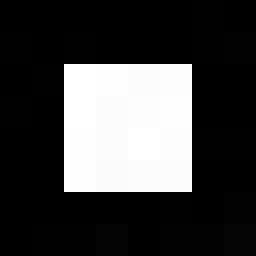

In [ ]:
img